# 取得Mask

In [71]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import concurrent.futures
from draw import draw_bounding_box_on_image as draw
from PIL import Image

In [2]:
# Initialize the COCO api for instance annotations

coco_path = r"C:\Users\sky66\fiftyone\coco-2017\raw\\"

val=COCO(coco_path+"instances_val2017.json")
train=COCO(coco_path+"instances_train2017.json")

# Load the categories in a variable
# catIDs = coco.getCatIds()
# cats = coco.loadCats(catIDs)

val_catIds = val.getCatIds(catNms=["person"]) 
val_imgIds = val.getImgIds(catIds=val_catIds)

train_catIds = train.getCatIds(catNms=["person"]) 
train_imgIds = train.getImgIds(catIds=train_catIds)

# img = coco.loadImgs(imgIds[0])[0]

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
loading annotations into memory...
Done (t=16.05s)
creating index...
index created!


In [72]:
train_imgIds[0]

262145

In [73]:
train.loadImgs(train_imgIds[0])[0]

{'license': 2,
 'file_name': '000000262145.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000262145.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-20 02:07:55',
 'flickr_url': 'http://farm8.staticflickr.com/7187/6967031859_5f08387bde_z.jpg',
 'id': 262145}

In [81]:
def mask(imgIds, catIds, coco, name):
    for img in imgIds:
        img = coco.loadImgs(img)[0]
        if img['file_name']==name:
            break    
            
    # print(img)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)[0]
    bbox = anns["bbox"]
    mask = coco.annToMask(anns)
    return mask, bbox

In [75]:
imgPath = r"C:\Users\sky66\fiftyone\coco-2017\train\data"+"\\"
imgs = list(os.listdir(imgPath))

In [76]:
# https://www.cnblogs.com/ywheunji/p/12052770.html

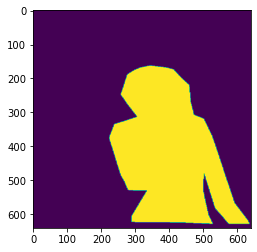

In [77]:
plt.imshow(mask(train_imgIds, train_catIds, train, imgs[0])[0])

x0:162, y0:167, x1:628, y1:478
x0:162, y0:167, x1:628, y1:478


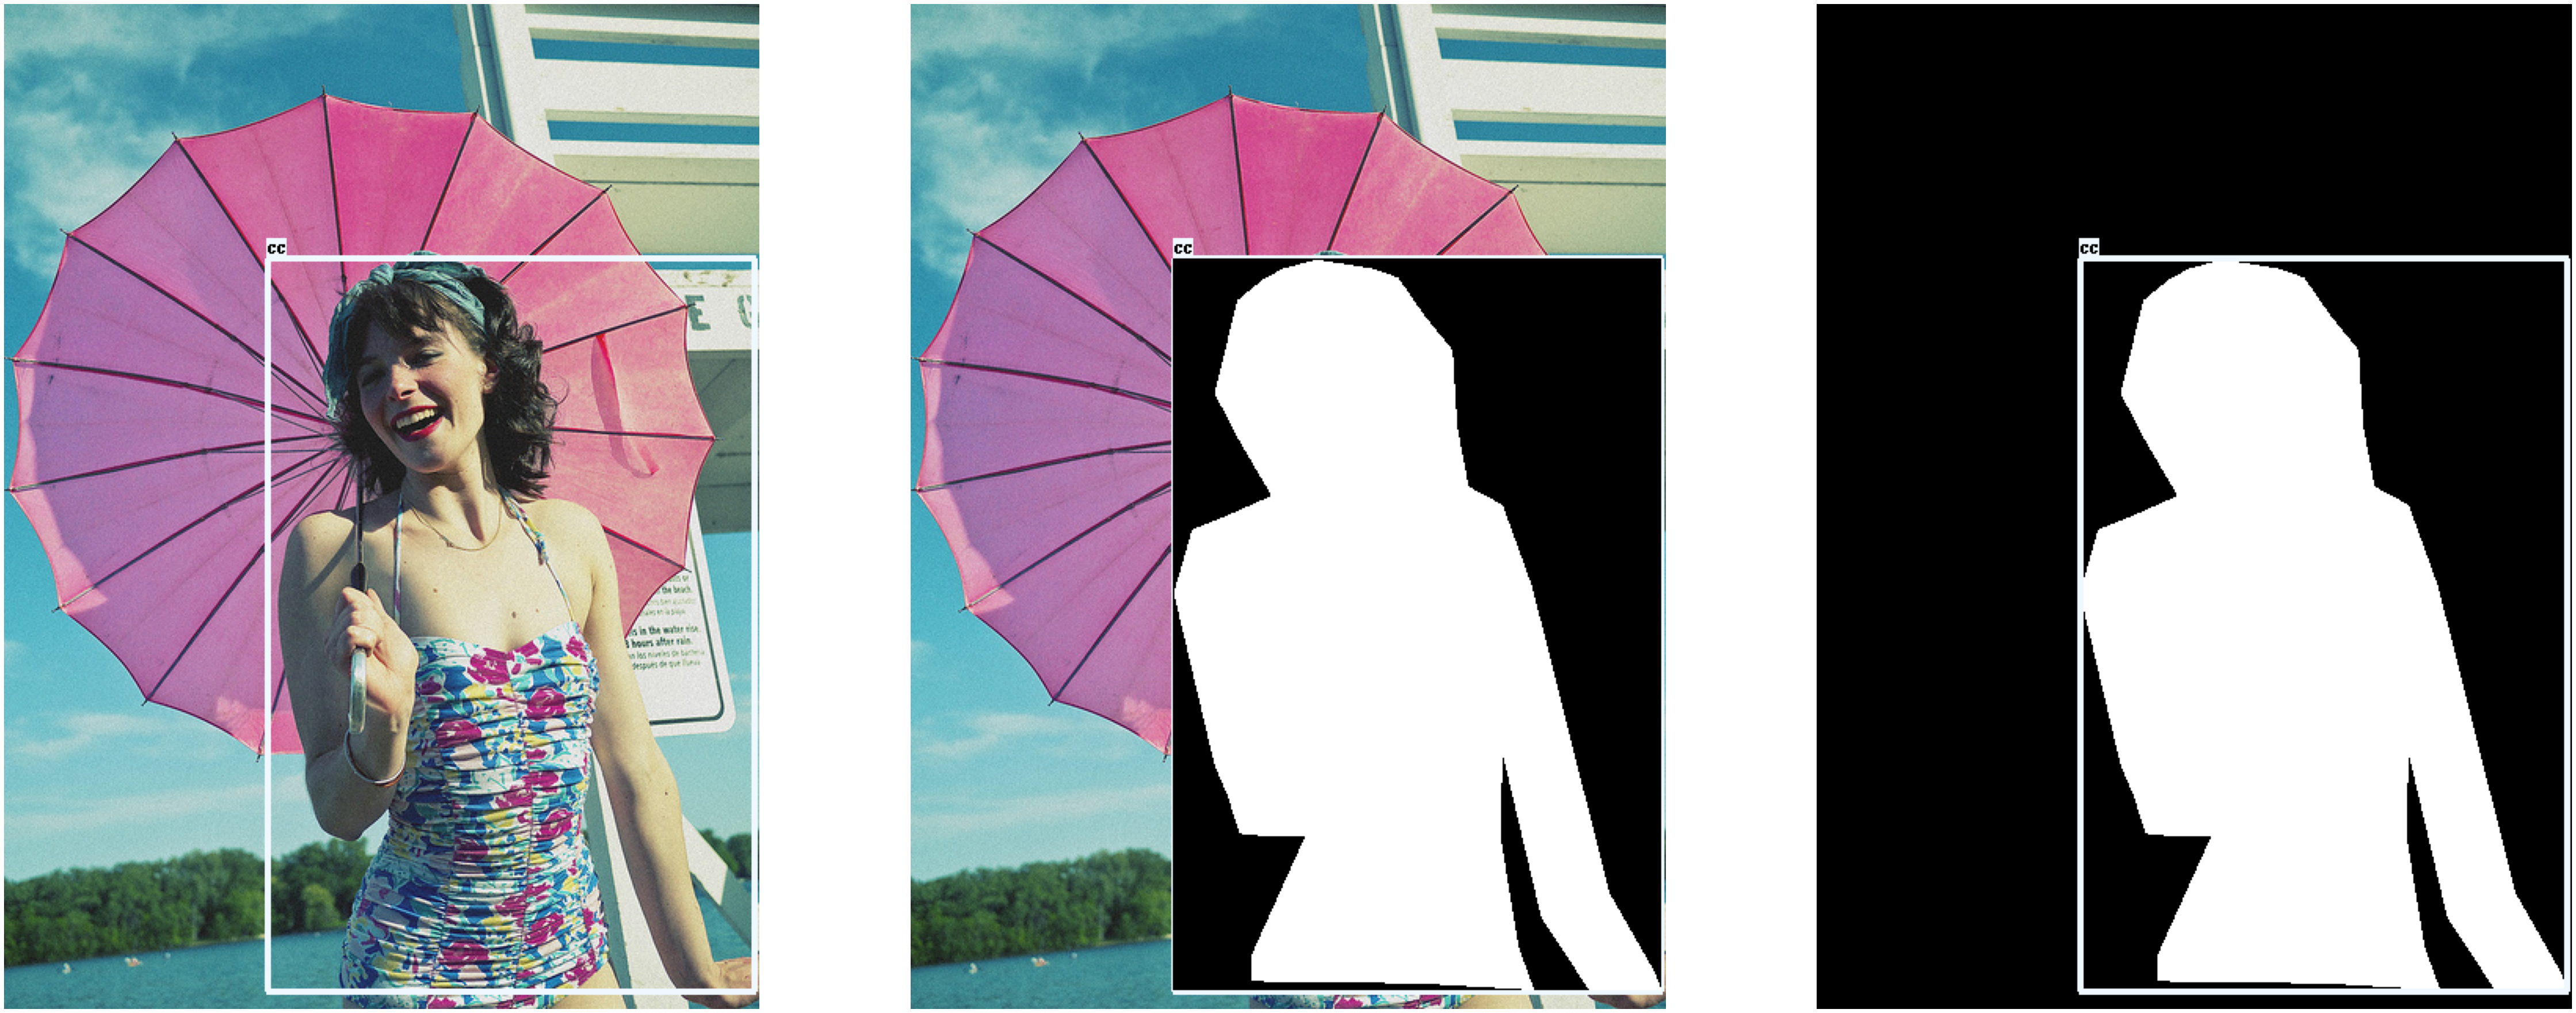

In [88]:
def vw(ids, isMask=True, isTrain=True, imgPath=None):
    name = imgs[ids]
    if isTrain:
        b, d = mask(train_imgIds, train_catIds, train, name)
    else:
        b, d = mask(val_imgIds, val_catIds, val, name)
        
    if isMask:
        b = cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)*255
    else:
        b = cv2.imread(os.path.join(imgPath,imgs[ids]))
        b = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
    s = b.shape
    x, y, w, h = d
    x0, y0, x1, y1 = [int(r) for r in [y, x, y+h, x+w]]
    print("x0:{}, y0:{}, x1:{}, y1:{}".format(x0, y0, x1, y1))
    bp = b[x0:x1, y0:y1]
    ymin, xmin, ymax, xmax = y/s[0], x/s[1], (y+h)/s[0], (x+w)/s[1]
    b = draw(b, ymin, xmin, ymax, xmax, display_str_list=["CC"])
    b = np.array(b, dtype="uint8")
    # b = Image.fromarray(np.uint8( np.array(b) ) )
    return b, bp, [x0,x1,y0,y1] # b is origin image, bp is croped-image

def vi(imgs): # 傳入數張圖片，依序顯示。
    fig, ax = plt.subplots(1, len(imgs), figsize=(80,80))
    for i in range(0,len(imgs)):                       
        ax[i].imshow(imgs[i])
        ax[i].axis('off')
    plt.show()     

ids = 0
ms, gt, box = vw(ids, isMask=True)
ig, g1, box = vw(ids, isMask=False, isTrain=True, imgPath=imgPath)
pr = ig.copy()
pr[box[0]:box[1], box[2]:box[3]] = gt
vi([ig, pr, ms])

In [104]:
def bask(ids, imgPath, isTrain=True):
    name = imgs[ids]
    if isTrain:
        Mask, d = mask(train_imgIds, train_catIds, train, name)
    else:
        Mask, d = mask(val_imgIds, val_catIds, val, name)        
    
    img = cv2.imread(os.path.join(imgPath,name))
    Mask = Mask*255
        
    s = img.shape
    
    x, y, w, h = d
    x0, y0, x1, y1 = [int(r) for r in [y, x, y+h, x+w]]
    
    if w<20 or h<20 :
        raise Error
        
    img = img[x0:x1, y0:y1]
    Mask = Mask[x0:x1, y0:y1]
    
    img = cv2.resize(img,(256,256))
    Mask = cv2.resize(Mask,(256,256))
    
    return img, Mask

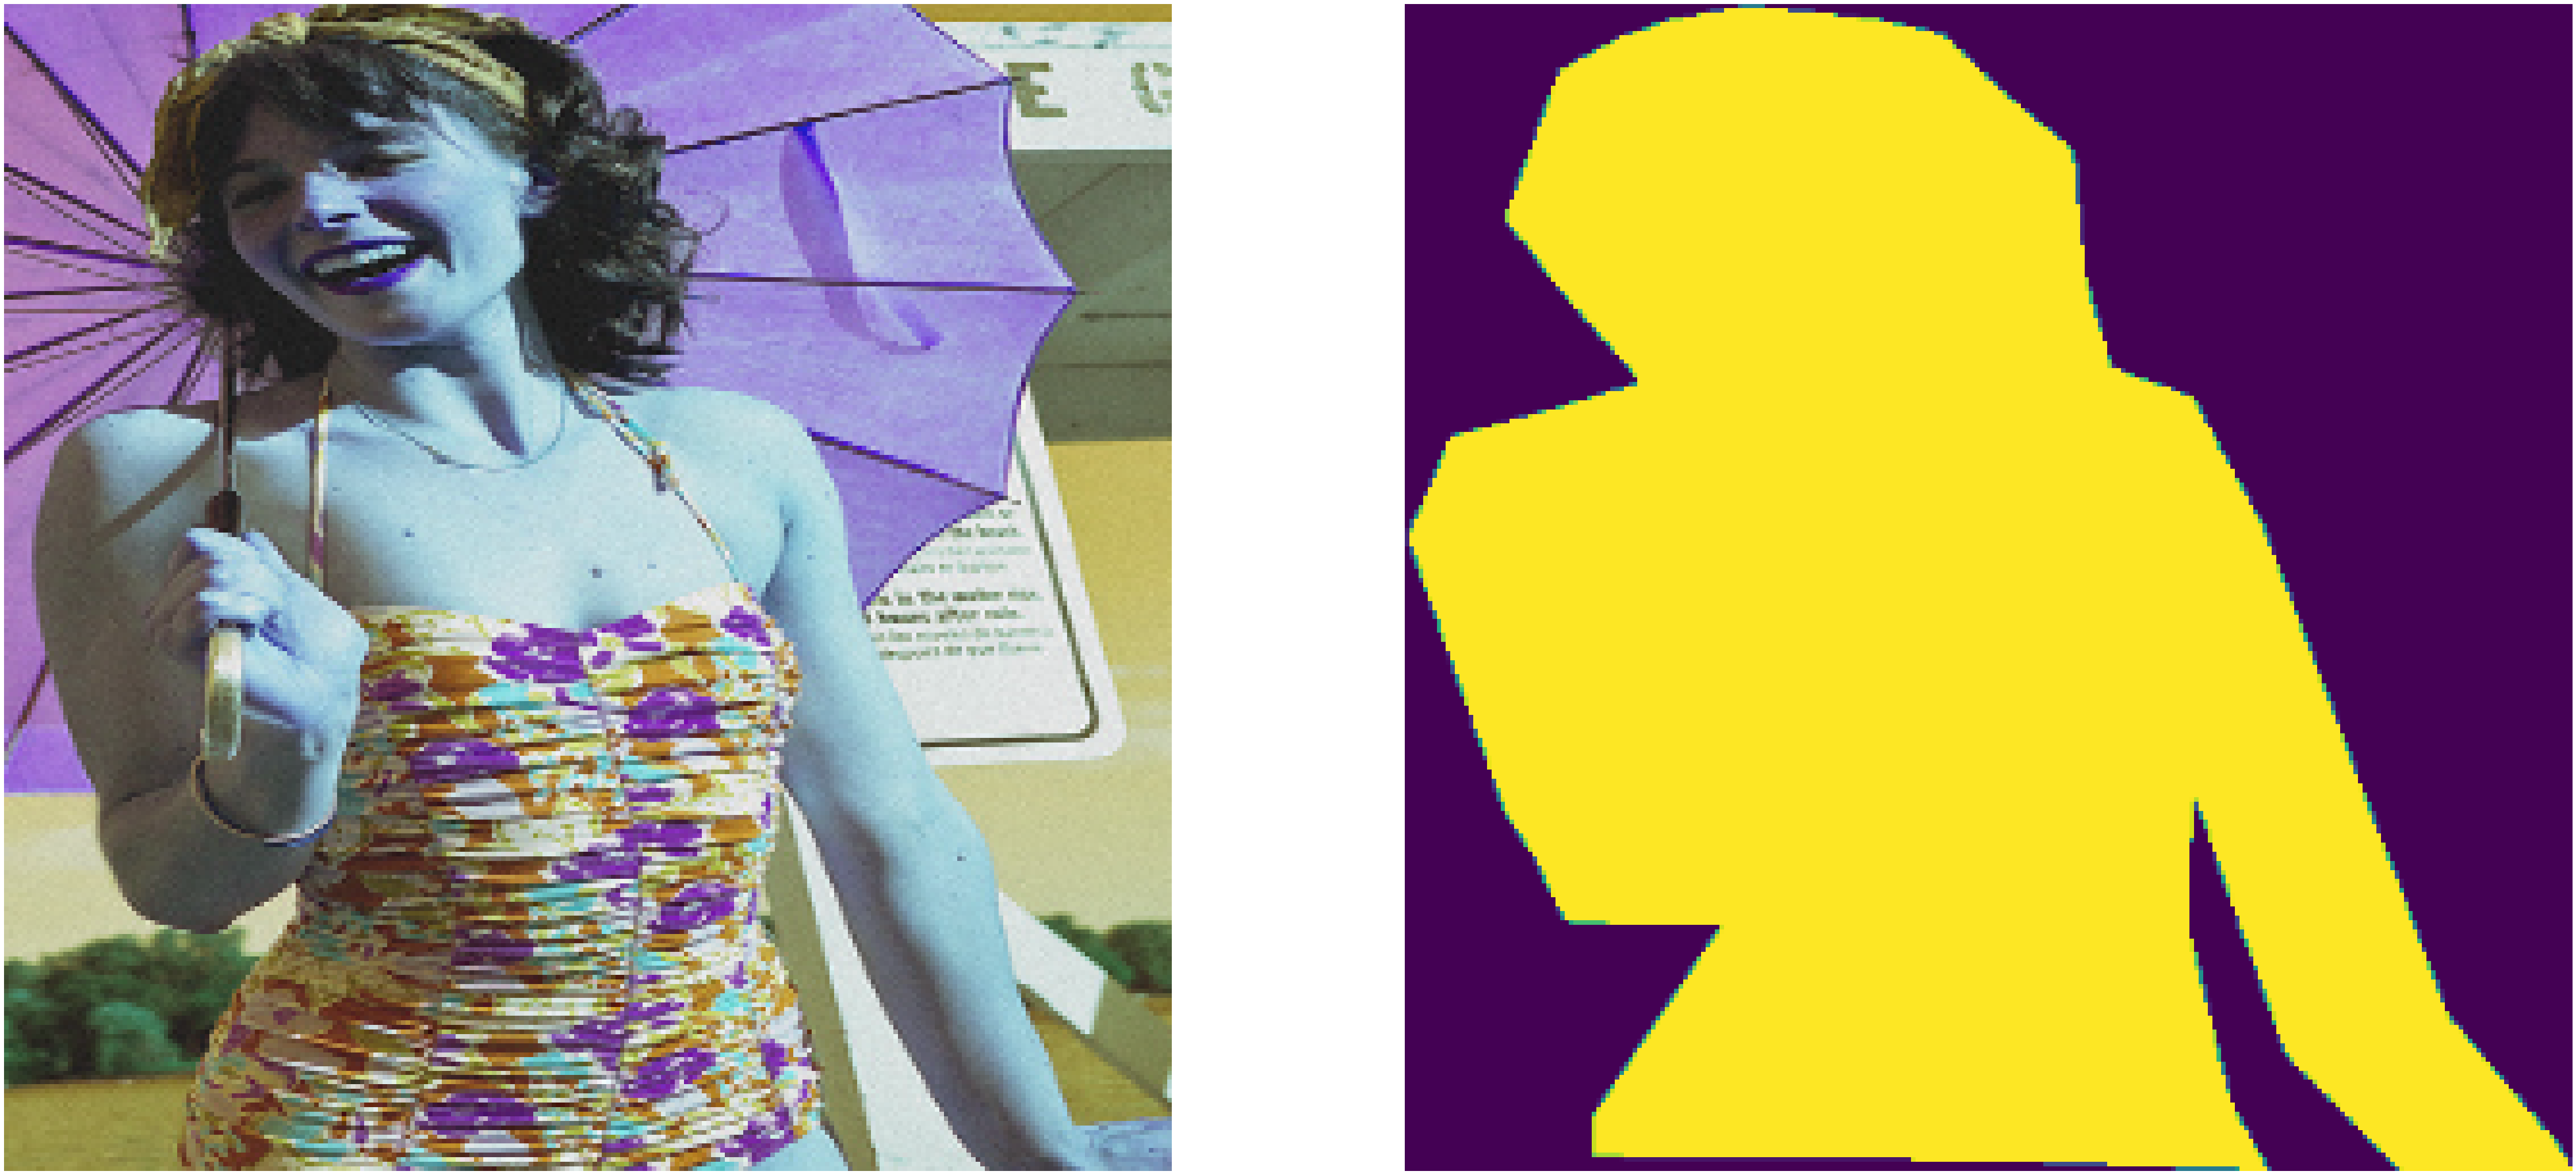

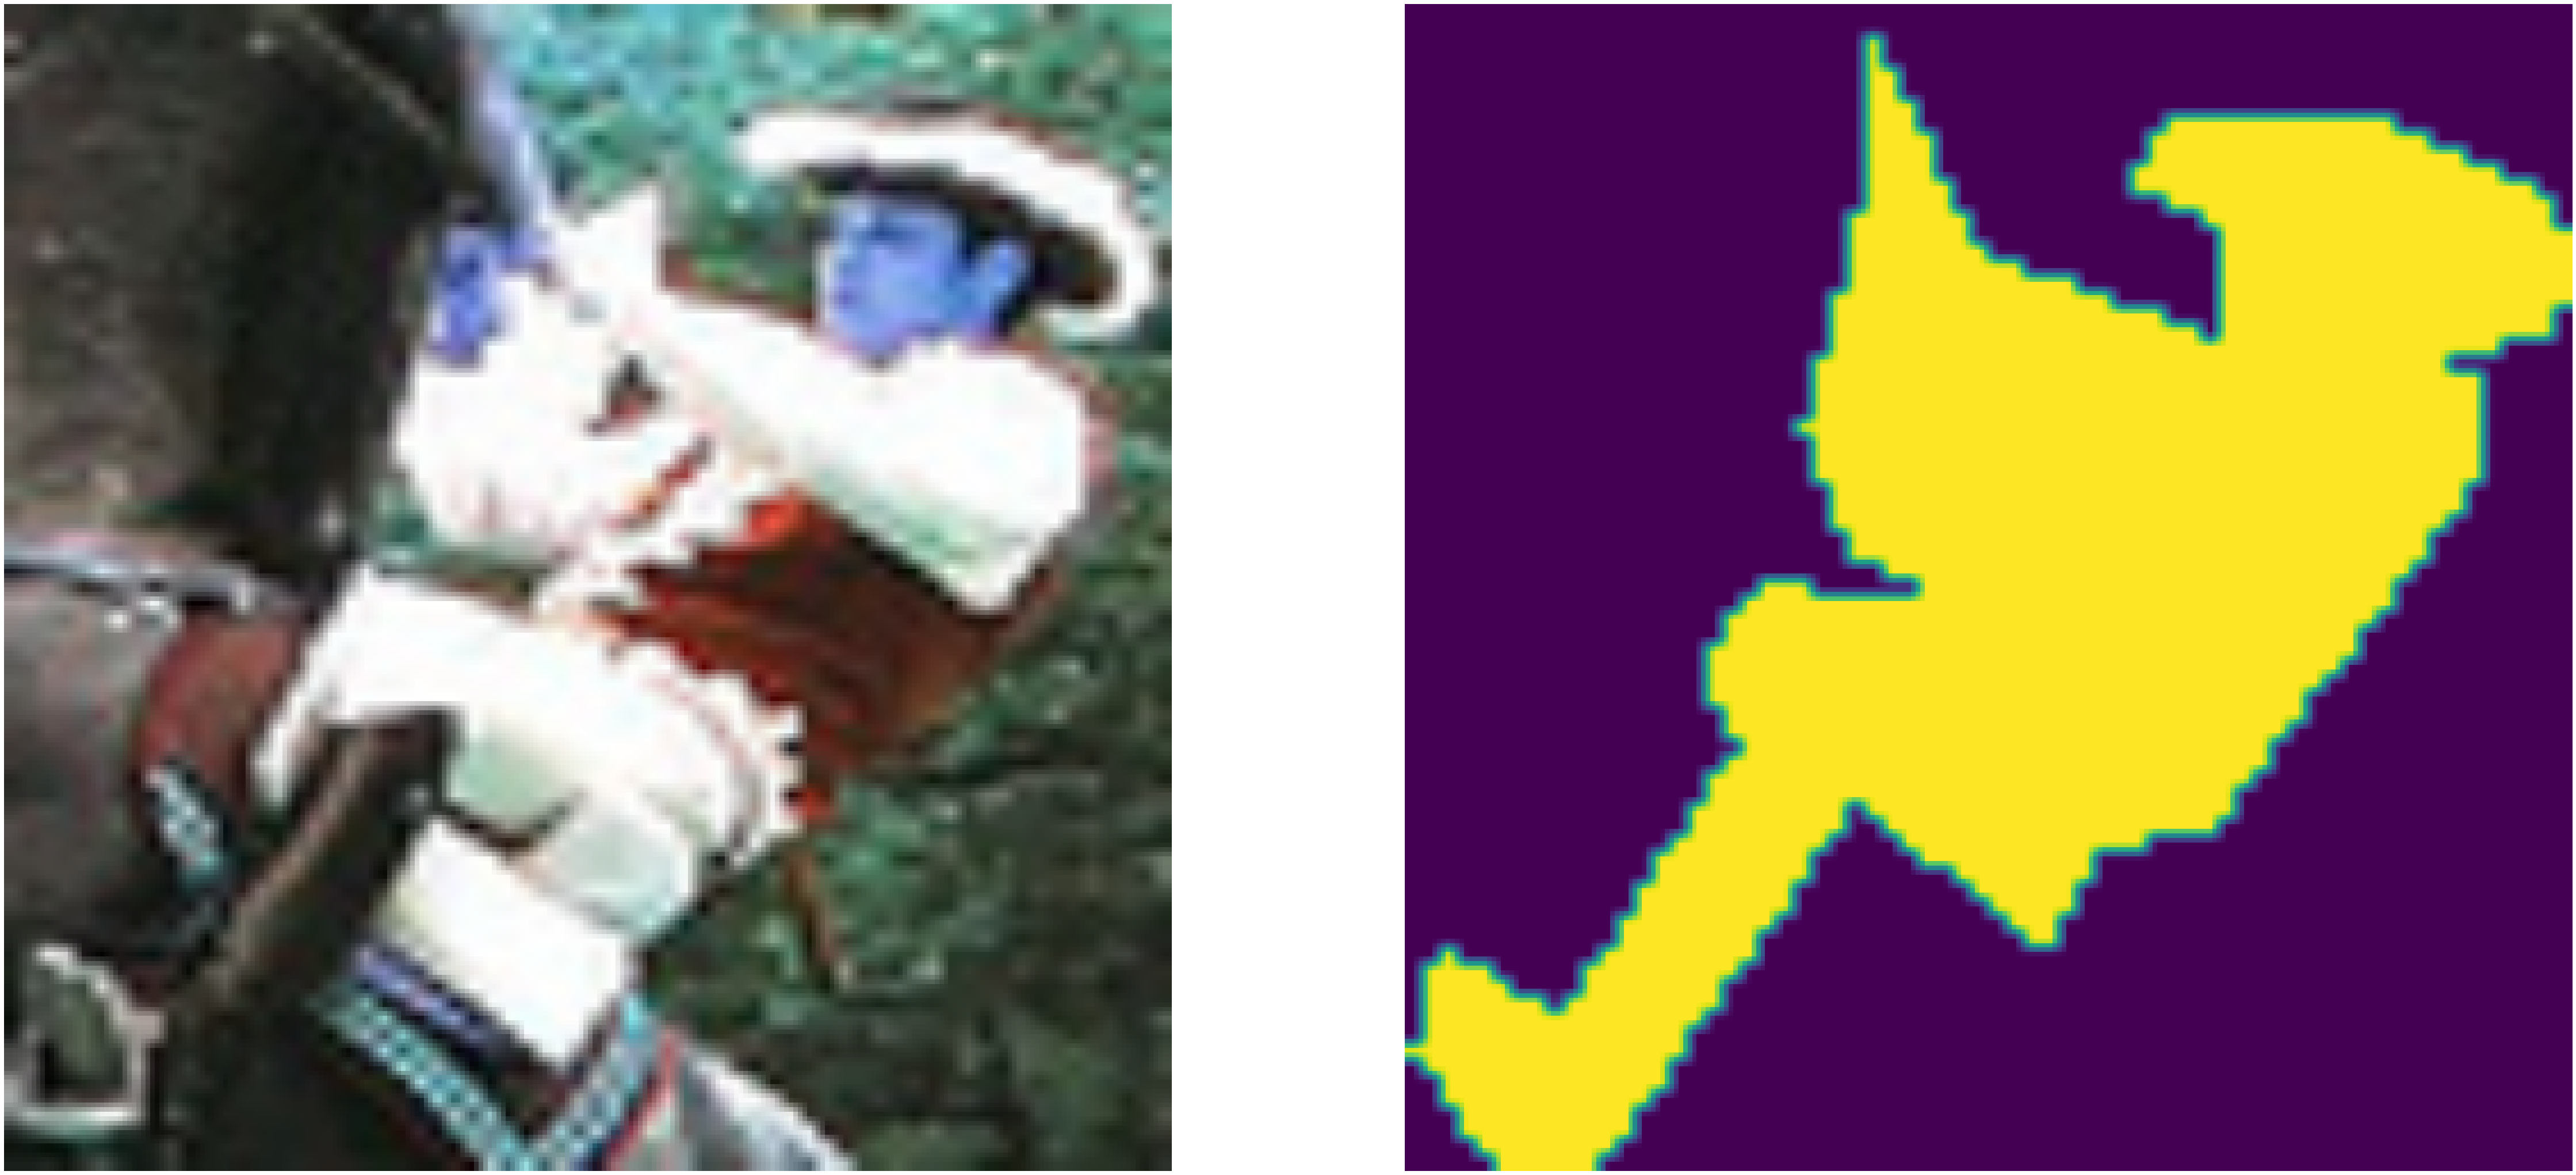

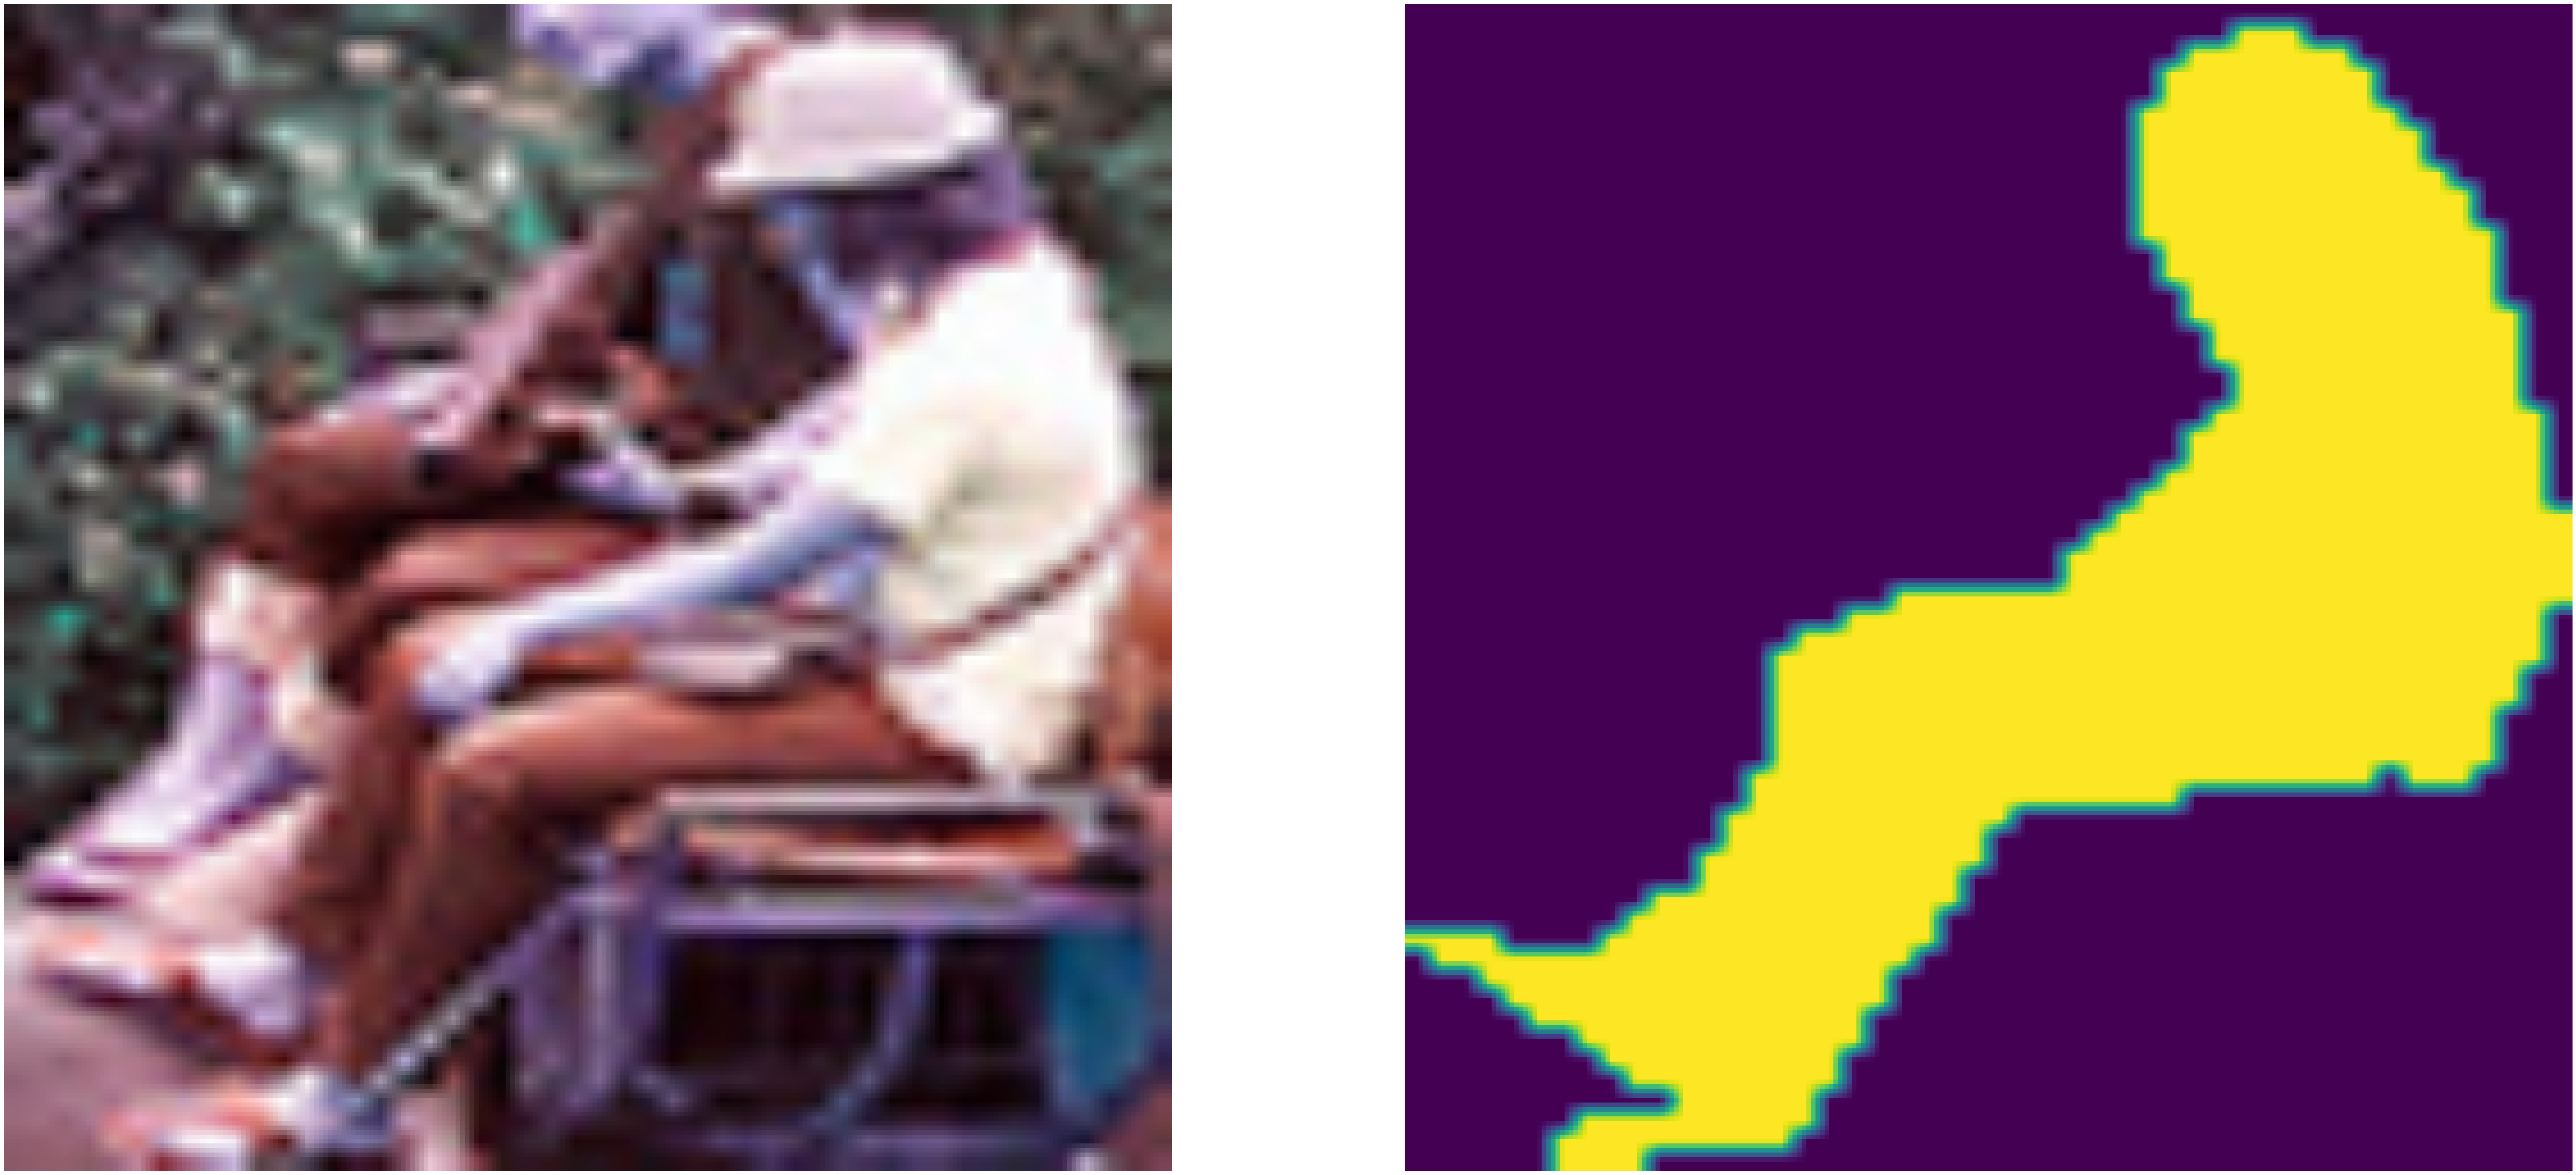

This picture bbox width or height <20


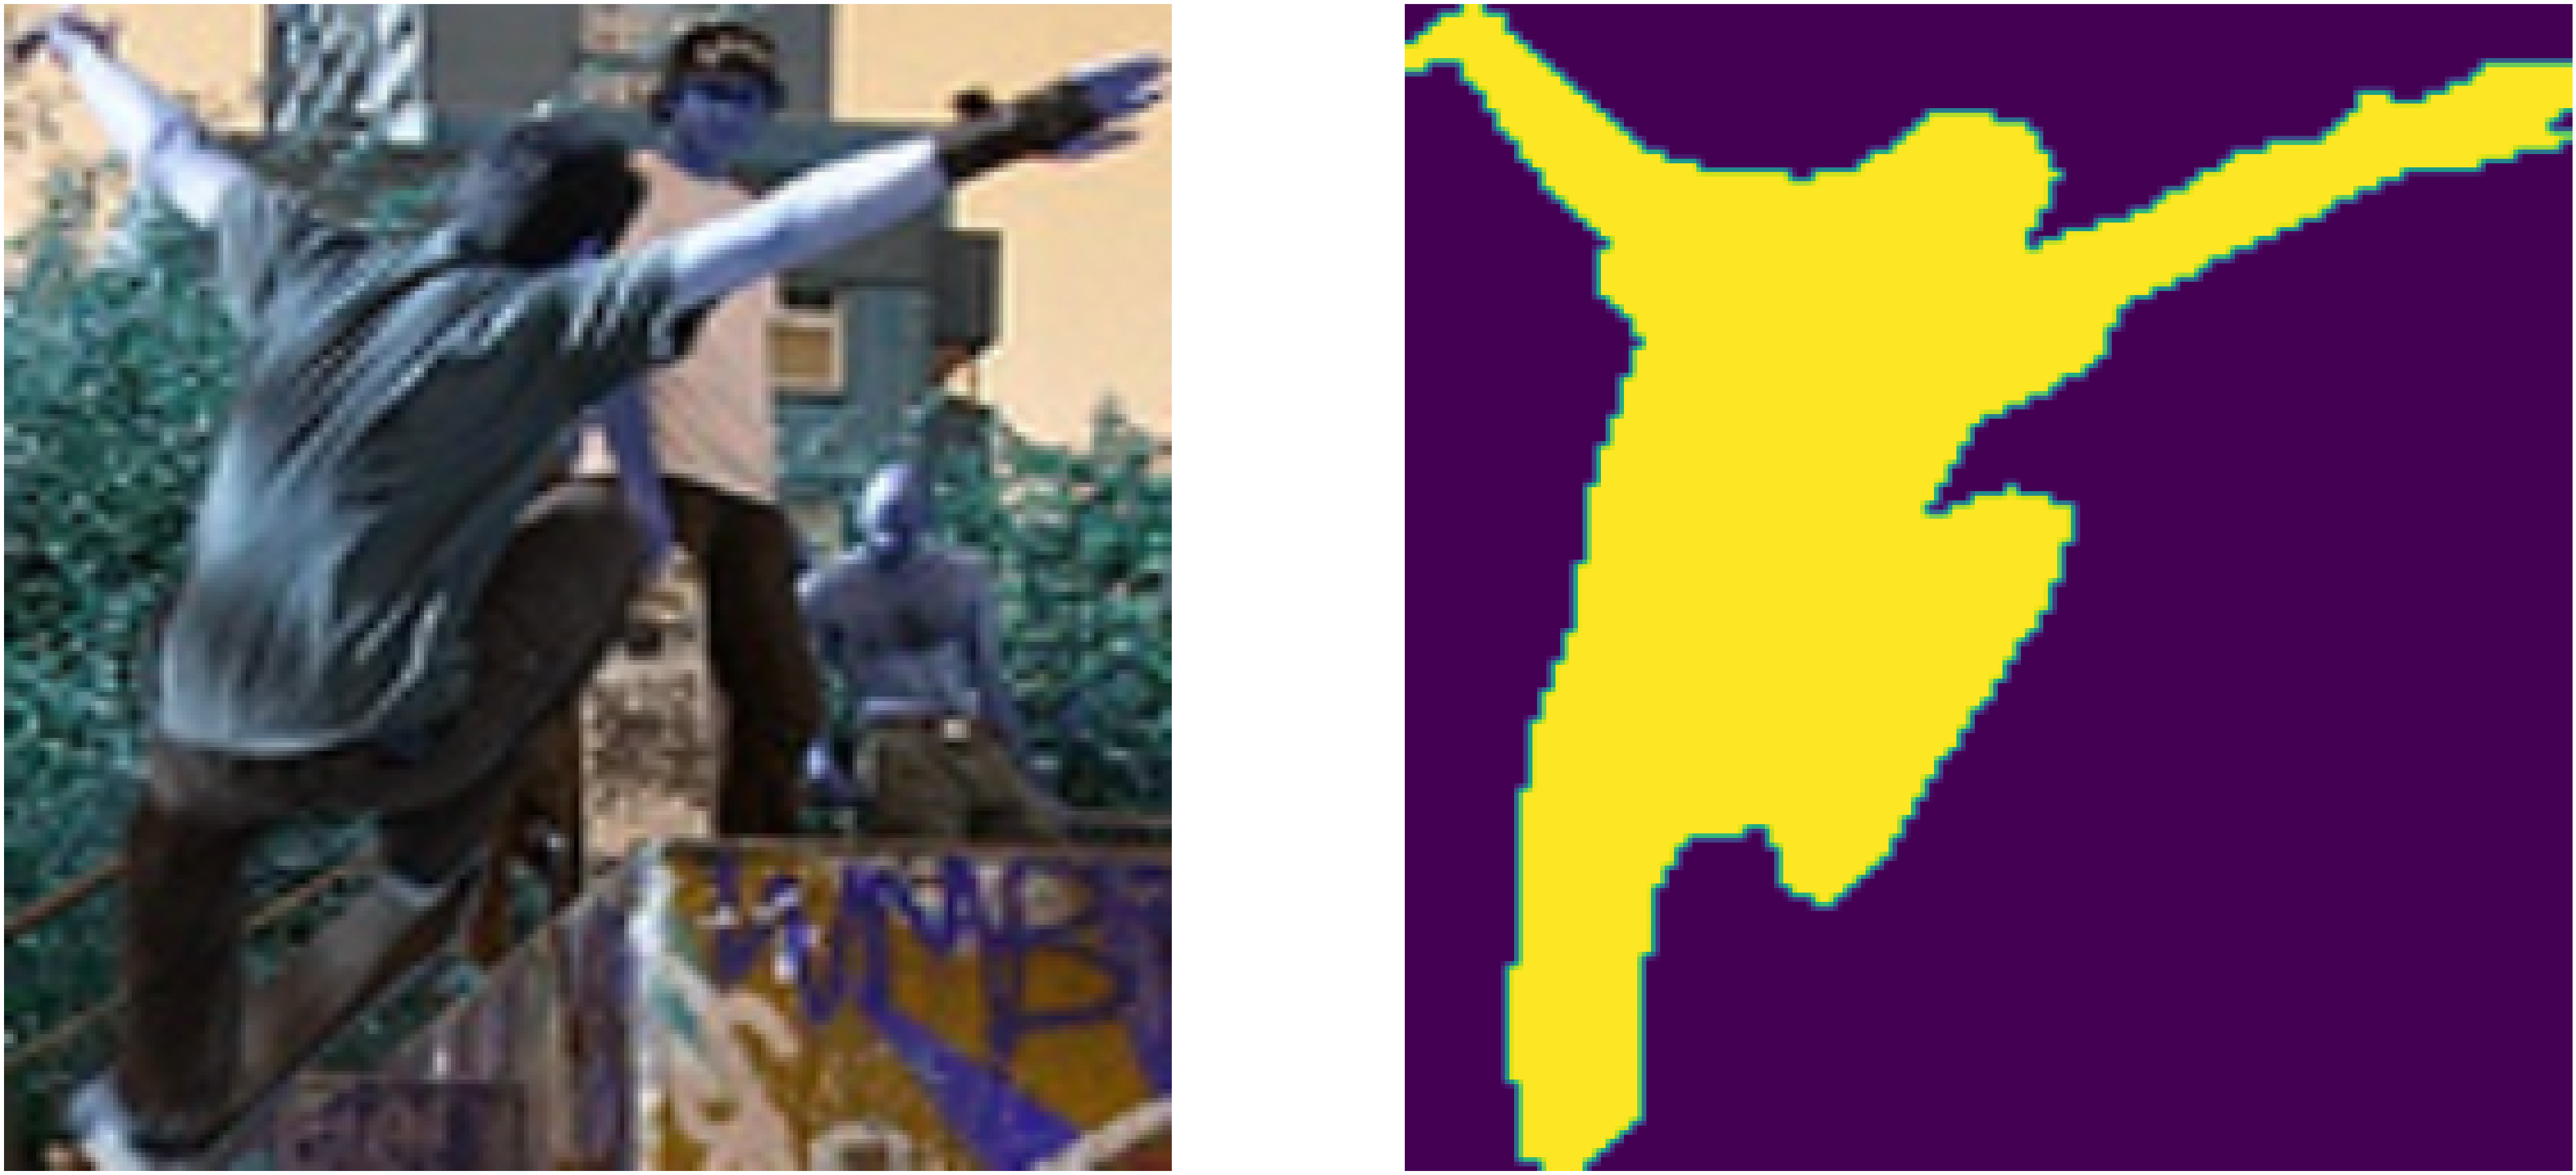

In [105]:
for i in range(0,5):
    try:
        i,m = bask(i, imgPath, isTrain=True)
        vi([i,m])
    except:
        print("This picture bbox width or height <20")

In [106]:
d = bask(0, imgPath)

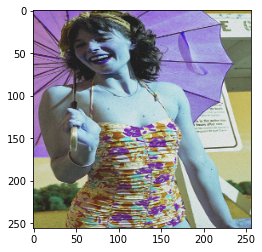

In [107]:
plt.imshow(d[0])

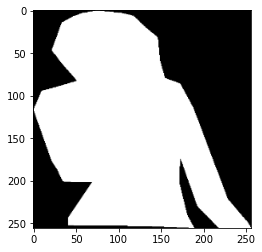

In [108]:
plt.imshow(d[1], cmap="gray")

In [109]:
d[1].shape

(256, 256)

In [110]:
def stored(path, InewPath, MnewPath, ids, isTrain=True):
    name = imgs[ids]
    try:
        i, m = bask(ids, path, isTrain)
        if isTrain:
            cv2.imwrite(MnewPath+"\\train_"+name, m)
            cv2.imwrite(InewPath+"\\train_"+name, i)
        else:    
            cv2.imwrite(MnewPath+"\\val_"+name, m)
            cv2.imwrite(InewPath+"\\val_"+name, i)  
    except:
        pass

In [111]:
imgPath = r"C:\Users\sky66\fiftyone\coco-2017\train\data"+"\\"
imgs = list(os.listdir(imgPath))
stored(imgPath, r"C:\Users\sky66\fiftyone\coco-2017\raw\img", r"C:\Users\sky66\fiftyone\coco-2017\raw\mask", 0, isTrain=True)

In [145]:
# imgPath = r"C:\Users\sky66\fiftyone\coco-2017\raw\val2017"+"\\"
# imgs = list(os.listdir(imgPath))
# stored(imgPath, r"C:\Users\sky66\fiftyone\coco-2017\raw\img", r"C:\Users\sky66\fiftyone\coco-2017\raw\mask", 150, isTrain=False)

In [112]:
def save(imgs, path, InewPath, MnewPath, isTrain=True):
    tar = imgs
    Max = 30
    for n in range(0,len(tar),Max):
        with concurrent.futures.ThreadPoolExecutor(max_workers=Max) as executor:
            for i in range(n, n+len(tar[n:n+Max])):
                executor.submit(stored, path, InewPath, MnewPath, i, isTrain) 

In [113]:
imgPath = r"C:\Users\sky66\fiftyone\coco-2017\train\data"+"\\"
imgs = list(os.listdir(imgPath))
save(imgs, imgPath, r"C:\Users\sky66\fiftyone\coco-2017\raw\img", r"C:\Users\sky66\fiftyone\coco-2017\raw\mask", isTrain=True)

In [174]:
# imgPath = r"C:\Users\sky66\fiftyone\coco-2017\raw\val2017"+"\\"
# imgs = list(os.listdir(imgPath))
# save(imgs, imgPath, r"C:\Users\sky66\fiftyone\coco-2017\raw\img", r"C:\Users\sky66\fiftyone\coco-2017\raw\mask", isTrain=False)